In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [7]:
s_1 = []
s_2 = []
s_3 = []

In [10]:
c_1_01 = []
c_2_01 = []
c_3_01 = []

c_1_p1 = []
c_2_p1 = []
c_3_p1 = []

c_1_1 = []
c_2_1 = []
c_3_1 = []

c_1_5 = []
c_2_5 = []
c_3_5 = []

c_1_10 = []
c_2_10 = []
c_3_10 = []

1 of 8: 100/0/standard 

500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5fb2048>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2572, -3.9297, -4.2729,  ..., -3.6657, -3.4537, -3.0763],
          [-3.9392, -4.9823, -5.6233,  ..., -4.5114, -4.1316, -3.5173],
          [-4.4422, -5.9086, -6.7678,  ..., -5.3323, -4.7829, -3.9245],
          ...,
          [-3.3249, -3.8253, -4.3497,  ..., -6.1674, -5.1652, -4.4203],
          [-2.9583, -3.2895, -3.7113,  ..., -5.1605, -4.4421, -3.9292],
          [-2.7116, -3.0950, -3.3552,  ..., -4.2543, -3.8496, -3.2408]]]],
       device='cuda:0'), tensor([[[[-3.2051, -3.9112, -4.1735,  ..., -4.4074, -4.1947, -3.4975],
          [-3.7714, -4.7005, -5.0249,  ..., -5.3822, -5.0717, -4.1084],
          [-4.1418, -5.2691, -5.5556,  ..., -6.1332, -5.6383, -4.4569],
          ...,
          [-4.3689, -6.2961, -8.6345,  ..., -7.9851, -6.3951,

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6008898>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=67, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2414, -3.8950, -4.1986,  ..., -3.7056, -3.4395, -3.0532],
          [-3.9293, -4.9383, -5.5056,  ..., -4.5795, -4.1033, -3.4795],
          [-4.4209, -5.8113, -6.5747,  ..., -5.3574, -4.7011, -3.8458],
          ...,
          [-3.1354, -3.5325, -3.9992,  ..., -5.6525, -4.8138, -4.1607],
          [-2.7474, -2.9877, -3.3735,  ..., -4.8534, -4.2030, -3.7289],
          [-2.5481, -2.8635, -3.1021,  ..., -4.1169, -3.7004, -3.1098]]]],
       device='cuda:0'), tensor([[[[-3.1729, -3.7736, -3.9835,  ..., -4.4175, -4.1624, -3.4637],
          [-3.6955, -4.4307, -4.6770,  ..., -5.2774, -4.9422, -4.0183],
          [-4.0066, -4.8555, -5.0530,  ..., -5.8839, -5.3892, -4.3281],
          ...,
          [-4.0754, -5.1072, -6.8720,  ..., -7.5230, -5.9487, -

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86507b7240>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=54, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2072, -3.8322, -4.1104,  ..., -3.6432, -3.4067, -3.0508],
          [-3.8409, -4.7739, -5.2918,  ..., -4.4286, -4.0202, -3.4603],
          [-4.3004, -5.5741, -6.2888,  ..., -5.1688, -4.6004, -3.8216],
          ...,
          [-2.8186, -3.1512, -3.5878,  ..., -5.4995, -4.7554, -4.1457],
          [-2.5078, -2.7079, -3.0765,  ..., -4.7389, -4.1614, -3.7268],
          [-2.4134, -2.7014, -2.9142,  ..., -4.0623, -3.6647, -3.1007]]]],
       device='cuda:0'), tensor([[[[-3.0101, -3.4509, -3.6365,  ..., -4.2203, -4.0402, -3.4166],
          [-3.4517, -3.9944, -4.2111,  ..., -5.0323, -4.7868, -3.9691],
          [-3.7462, -4.4429, -4.6329,  ..., -5.5905, -5.1965, -4.2797],
          ...,
          [-3.9366, -4.8229, -6.0614,  ..., -7.6474, -5.9486, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6904198>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=72, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2162, -3.8457, -4.1347,  ..., -3.7846, -3.5275, -3.1205],
          [-3.8515, -4.7976, -5.3354,  ..., -4.6474, -4.2042, -3.5702],
          [-4.3110, -5.6029, -6.3409,  ..., -5.4172, -4.8108, -3.9471],
          ...,
          [-3.0414, -3.3798, -3.8617,  ..., -5.3351, -4.6347, -4.0844],
          [-2.6774, -2.8718, -3.2659,  ..., -4.5929, -4.0543, -3.6722],
          [-2.5043, -2.7932, -3.0196,  ..., -3.9925, -3.6069, -3.0716]]]],
       device='cuda:0'), tensor([[[[-3.0091, -3.4203, -3.5595,  ..., -4.1895, -4.0420, -3.4296],
          [-3.4535, -3.9703, -4.1465,  ..., -4.9514, -4.7555, -3.9685],
          [-3.7391, -4.4187, -4.5754,  ..., -5.4192, -5.0975, -4.2485],
          ...,
          [-3.9992, -4.9078, -6.2451,  ..., -7.2351, -5.7214, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d679e780>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=61, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1963, -3.7940, -4.0697,  ..., -3.6169, -3.3823, -3.0510],
          [-3.8017, -4.6910, -5.1963,  ..., -4.3497, -3.9499, -3.4437],
          [-4.2470, -5.4688, -6.1627,  ..., -5.0375, -4.4907, -3.7861],
          ...,
          [-3.1040, -3.3970, -3.8290,  ..., -5.3553, -4.5672, -4.0295],
          [-2.7313, -2.8921, -3.2409,  ..., -4.5379, -3.9634, -3.6060],
          [-2.5466, -2.8209, -3.0115,  ..., -3.9758, -3.5692, -3.0419]]]],
       device='cuda:0'), tensor([[[[-2.9847, -3.3449, -3.5116,  ..., -4.0654, -3.9247, -3.3633],
          [-3.4063, -3.8448, -4.0373,  ..., -4.7264, -4.5467, -3.8621],
          [-3.6869, -4.2978, -4.4812,  ..., -5.1284, -4.8434, -4.1413],
          ...,
          [-4.0223, -4.9513, -6.3436,  ..., -6.7415, -5.6211, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5aaa630>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=54, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2042, -3.8153, -4.0812,  ..., -3.5272, -3.3238, -3.0144],
          [-3.8343, -4.7533, -5.2475,  ..., -4.2486, -3.8867, -3.3978],
          [-4.2929, -5.5545, -6.2407,  ..., -4.9796, -4.4563, -3.7539],
          ...,
          [-3.2389, -3.5880, -4.0351,  ..., -5.4765, -4.7114, -4.1279],
          [-2.8148, -2.9940, -3.3302,  ..., -4.6937, -4.1091, -3.7036],
          [-2.5882, -2.8599, -3.0446,  ..., -4.0466, -3.6502, -3.0987]]]],
       device='cuda:0'), tensor([[[[-2.9810, -3.3441, -3.4955,  ..., -4.0326, -3.9054, -3.3627],
          [-3.4084, -3.8570, -4.0358,  ..., -4.7179, -4.5328, -3.8568],
          [-3.7013, -4.3243, -4.5097,  ..., -5.1946, -4.8833, -4.1382],
          ...,
          [-4.1803, -5.2041, -6.5837,  ..., -7.1840, -5.8428, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5aaa080>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=68, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1499, -3.7219, -3.9578,  ..., -3.5776, -3.3472, -3.0142],
          [-3.7492, -4.5939, -5.0307,  ..., -4.3409, -3.9428, -3.4059],
          [-4.1892, -5.3436, -5.9482,  ..., -5.0853, -4.5222, -3.7590],
          ...,
          [-3.0413, -3.3648, -3.7884,  ..., -5.4805, -4.7328, -4.1403],
          [-2.6649, -2.8340, -3.1767,  ..., -4.6874, -4.1229, -3.7116],
          [-2.5049, -2.7642, -2.9587,  ..., -4.0615, -3.6599, -3.1024]]]],
       device='cuda:0'), tensor([[[[-2.9927, -3.3637, -3.5577,  ..., -4.1362, -3.9636, -3.3857],
          [-3.4774, -3.9878, -4.2582,  ..., -4.8853, -4.6476, -3.9146],
          [-3.8467, -4.5801, -4.8409,  ..., -5.4080, -5.0363, -4.2295],
          ...,
          [-3.9860, -4.8581, -6.3427,  ..., -7.0646, -5.8027, -4.3217

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdd5a588>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1662, -3.7631, -4.0163,  ..., -3.6812, -3.4559, -3.0846],
          [-3.7603, -4.6324, -5.1036,  ..., -4.4896, -4.0916, -3.5099],
          [-4.2126, -5.4203, -6.0753,  ..., -5.2612, -4.6920, -3.8872],
          ...,
          [-3.2358, -3.6474, -4.1099,  ..., -6.0338, -5.0919, -4.3788],
          [-2.8341, -3.0834, -3.4537,  ..., -5.1517, -4.4492, -3.9267],
          [-2.6071, -2.9245, -3.1539,  ..., -4.2696, -3.8560, -3.2346]]]],
       device='cuda:0'), tensor([[[[-3.0399, -3.4805, -3.7154,  ..., -4.2139, -4.0619, -3.4573],
          [-3.5282, -4.1335, -4.5029,  ..., -5.0141, -4.7998, -4.0133],
          [-3.9304, -4.8293, -5.2705,  ..., -5.6589, -5.2693, -4.3371],
          ...,
          [-4.0629, -5.1406, -6.9064,  ..., -8.5009, -6.4615, -4.447

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdc46828>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=58, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2475, -3.9035, -4.1919,  ..., -3.7329, -3.5053, -3.1073],
          [-3.9184, -4.9371, -5.4744,  ..., -4.6194, -4.2048, -3.5640],
          [-4.4078, -5.8359, -6.5803,  ..., -5.4497, -4.8555, -3.9713],
          ...,
          [-3.4407, -3.9779, -4.5572,  ..., -6.2264, -5.2246, -4.4703],
          [-3.0362, -3.3901, -3.8632,  ..., -5.3370, -4.5899, -4.0228],
          [-2.7535, -3.1390, -3.4280,  ..., -4.4032, -3.9628, -3.3126]]]],
       device='cuda:0'), tensor([[[[-3.0703, -3.5372, -3.7452,  ..., -4.3255, -4.1481, -3.5051],
          [-3.5549, -4.1312, -4.4086,  ..., -5.1814, -4.9473, -4.1004],
          [-3.8929, -4.6554, -4.9792,  ..., -5.8356, -5.4435, -4.4410],
          ...,
          [-4.1842, -5.5508, -7.5231,  ..., -8.6821, -6.7748, -

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdc8d208>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1996, -3.8128, -4.0778,  ..., -3.8245, -3.5627, -3.1313],
          [-3.8127, -4.7256, -5.2144,  ..., -4.7199, -4.2733, -3.5945],
          [-4.2654, -5.5259, -6.2090,  ..., -5.5169, -4.9073, -3.9860],
          ...,
          [-3.0944, -3.4795, -3.9631,  ..., -5.5796, -4.8305, -4.2204],
          [-2.7221, -2.9458, -3.3351,  ..., -4.8137, -4.2280, -3.7907],
          [-2.5336, -2.8346, -3.0697,  ..., -4.0870, -3.7109, -3.1461]]]],
       device='cuda:0'), tensor([[[[-2.9874, -3.3739, -3.5535,  ..., -4.3477, -4.1491, -3.4827],
          [-3.4186, -3.8837, -4.1004,  ..., -5.1224, -4.8902, -4.0322],
          [-3.7346, -4.3904, -4.6023,  ..., -5.6090, -5.2482, -4.3152],
          ...,
          [-3.8737, -4.9424, -6.7278,  ..., -8.7582, -6.4668, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6013cc0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=82, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1827, -3.7660, -4.0306,  ..., -3.6265, -3.4082, -3.0567],
          [-3.7649, -4.6237, -5.0986,  ..., -4.3722, -4.0072, -3.4625],
          [-4.2008, -5.3774, -6.0348,  ..., -5.0980, -4.5885, -3.8243],
          ...,
          [-3.1679, -3.5043, -3.9431,  ..., -5.4562, -4.7023, -4.1151],
          [-2.7796, -2.9651, -3.3174,  ..., -4.6720, -4.0987, -3.6881],
          [-2.5733, -2.8639, -3.0648,  ..., -4.0309, -3.6369, -3.0819]]]],
       device='cuda:0'), tensor([[[[-2.9545, -3.2759, -3.4551,  ..., -4.1263, -3.9522, -3.3771],
          [-3.3558, -3.7354, -3.9496,  ..., -4.8762, -4.6501, -3.8988],
          [-3.6607, -4.2239, -4.4322,  ..., -5.4215, -5.0596, -4.2139],
          ...,
          [-3.9099, -4.8687, -6.3674,  ..., -7.7781, -5.9800, -

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6a170f0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=74, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1844, -3.8026, -4.0897,  ..., -3.6050, -3.3930, -3.0474],
          [-3.8014, -4.7364, -5.2660,  ..., -4.4000, -4.0184, -3.4592],
          [-4.2701, -5.5669, -6.2939,  ..., -5.1963, -4.6454, -3.8463],
          ...,
          [-3.4619, -3.9884, -4.5241,  ..., -5.8910, -5.0524, -4.3723],
          [-3.0359, -3.3710, -3.8025,  ..., -5.0822, -4.4437, -3.9368],
          [-2.7419, -3.1146, -3.3718,  ..., -4.2647, -3.8710, -3.2505]]]],
       device='cuda:0'), tensor([[[[-2.9250, -3.2507, -3.4384,  ..., -4.2410, -4.0281, -3.4070],
          [-3.3366, -3.7241, -3.9723,  ..., -5.0804, -4.8052, -3.9675],
          [-3.6610, -4.2358, -4.5107,  ..., -5.7237, -5.3007, -4.3289],
          ...,
          [-4.1085, -5.3654, -7.1406,  ..., -8.2747, -6.3024, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6a17860>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=53, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0909, -3.6255, -3.8627,  ..., -3.6688, -3.4455, -3.0772],
          [-3.6371, -4.4056, -4.8441,  ..., -4.4935, -4.0958, -3.5075],
          [-4.0889, -5.1710, -5.7704,  ..., -5.3014, -4.7298, -3.9036],
          ...,
          [-3.4084, -3.9138, -4.4426,  ..., -5.8969, -4.9616, -4.2764],
          [-3.0004, -3.3254, -3.7539,  ..., -5.0361, -4.3413, -3.8428],
          [-2.7244, -3.0932, -3.3502,  ..., -4.2233, -3.8108, -3.1970]]]],
       device='cuda:0'), tensor([[[[-2.9609, -3.2958, -3.4833,  ..., -4.3757, -4.1781, -3.4988],
          [-3.3924, -3.7847, -4.0278,  ..., -5.3008, -5.0327, -4.1044],
          [-3.7572, -4.3272, -4.5364,  ..., -5.9502, -5.5315, -4.4484],
          ...,
          [-4.0024, -5.3057, -7.2567,  ..., -8.7588, -6.5008, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6a17d30>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=48, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1589, -3.7501, -4.0197,  ..., -3.6696, -3.4415, -3.0740],
          [-3.7513, -4.6338, -5.1314,  ..., -4.4832, -4.0773, -3.4926],
          [-4.2120, -5.4417, -6.1294,  ..., -5.2705, -4.6927, -3.8719],
          ...,
          [-3.3919, -3.8566, -4.3539,  ..., -5.8711, -5.0450, -4.3560],
          [-2.9663, -3.2470, -3.6433,  ..., -5.0609, -4.4345, -3.9251],
          [-2.6998, -3.0396, -3.2762,  ..., -4.2470, -3.8537, -3.2389]]]],
       device='cuda:0'), tensor([[[[-2.9323, -3.2645, -3.4541,  ..., -4.2854, -4.1031, -3.4635],
          [-3.3438, -3.7287, -3.9841,  ..., -5.1520, -4.9067, -4.0443],
          [-3.6631, -4.2334, -4.5242,  ..., -5.7604, -5.3647, -4.3697],
          ...,
          [-4.0337, -5.1608, -6.8528,  ..., -8.5043, -6.4407, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d614bda0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=67, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1692, -3.7733, -4.0444,  ..., -3.5998, -3.3943, -3.0430],
          [-3.7920, -4.7043, -5.2096,  ..., -4.4135, -4.0346, -3.4598],
          [-4.2597, -5.5249, -6.2167,  ..., -5.2033, -4.6510, -3.8435],
          ...,
          [-3.4019, -3.8873, -4.3774,  ..., -5.8756, -5.0388, -4.3322],
          [-2.9987, -3.3087, -3.7128,  ..., -5.0772, -4.4437, -3.9108],
          [-2.7281, -3.0838, -3.3300,  ..., -4.2669, -3.8740, -3.2439]]]],
       device='cuda:0'), tensor([[[[-2.9733, -3.3187, -3.5065,  ..., -4.3232, -4.1232, -3.4675],
          [-3.4125, -3.8170, -4.0752,  ..., -5.2150, -4.9520, -4.0589],
          [-3.7466, -4.3407, -4.6353,  ..., -5.8670, -5.4643, -4.4154],
          ...,
          [-4.1352, -5.2383, -6.7461,  ..., -8.0506, -6.3107, -

53916
mse total for all images [20822.762591046612, 31780.926817539468, 7091.550382195428, 9145.155216100677, 11217.53939864396, 4623.145065257326, 5173.06089617422, 6718.6953160004205, 6098.639055606495, 30429.294400917923, 5677.184845935029, 67799.11821773445, 5565.455921351007, 4674.819015513141, 8149.537741241484, 6350.838143369731, 28998.116310379213, 15966.575446325884, 9797.730382714475, 18450.11029513235, 4614.34277590871, 3879.2911915672253, 8423.514834754891, 5556.799478026122, 6218.351486306217, 6571.257988428899, 6040.238302769266, 5572.9339953887375, 6395.214540500587, 4342.673057390237]
362144.8731102201
mse yo 12071.49577034067
1500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdc6cf28>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=97, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3444, -4.0006, -4.3597,  ..., -3.5988, -3.4175, -3.0760],
          [-4.0578, -5.0782, -5.7567,  ..., 

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6a36470>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=47, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3377, -3.9829, -4.3054,  ..., -3.6336, -3.3850, -3.0361],
          [-4.0679, -5.0674, -5.6711,  ..., -4.4442, -4.0029, -3.4289],
          [-4.5799, -5.9649, -6.7659,  ..., -5.1525, -4.5531, -3.7775],
          ...,
          [-3.2793, -3.6605, -4.0969,  ..., -5.6184, -4.8072, -4.1348],
          [-2.9297, -3.1731, -3.5337,  ..., -4.9542, -4.3005, -3.7704],
          [-2.7087, -3.0579, -3.2881,  ..., -4.2864, -3.8386, -3.1908]]]],
       device='cuda:0'), tensor([[[[-3.2910, -3.8323, -4.0100,  ..., -4.4016, -4.2195, -3.5428],
          [-3.8683, -4.4983, -4.6662,  ..., -5.1675, -4.9562, -4.1020],
          [-4.2026, -4.9009, -4.9592,  ..., -5.6807, -5.3856, -4.4537],
          ...,
          [-4.2702, -5.2374, -6.9613,  ..., -6.3515, -5.6273, -

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6953710>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=47, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2720, -3.8734, -4.1704,  ..., -3.5920, -3.3784, -3.0544],
          [-3.9272, -4.8205, -5.3746,  ..., -4.3161, -3.9504, -3.4387],
          [-4.3957, -5.6065, -6.3587,  ..., -4.9821, -4.4721, -3.7795],
          ...,
          [-2.9781, -3.3155, -3.7041,  ..., -5.5488, -4.8217, -4.2184],
          [-2.6892, -2.9081, -3.2364,  ..., -4.9105, -4.3278, -3.8514],
          [-2.5647, -2.8943, -3.0967,  ..., -4.2717, -3.8535, -3.2316]]]],
       device='cuda:0'), tensor([[[[-3.1217, -3.5374, -3.7657,  ..., -4.2352, -4.1121, -3.4982],
          [-3.6049, -4.1047, -4.3807,  ..., -4.9882, -4.8256, -4.0599],
          [-3.9408, -4.5934, -4.8586,  ..., -5.5069, -5.2464, -4.3941],
          ...,
          [-4.0614, -4.8333, -5.9708,  ..., -6.6898, -5.7229, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6953cf8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=58, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2788, -3.8841, -4.1880,  ..., -3.7915, -3.5388, -3.1396],
          [-3.9328, -4.8331, -5.3985,  ..., -4.6386, -4.2153, -3.5889],
          [-4.4020, -5.6149, -6.3732,  ..., -5.3624, -4.7927, -3.9598],
          ...,
          [-3.1922, -3.5290, -3.9703,  ..., -5.4237, -4.7327, -4.1835],
          [-2.8652, -3.0695, -3.4271,  ..., -4.8024, -4.2568, -3.8230],
          [-2.6654, -2.9905, -3.2039,  ..., -4.2288, -3.8217, -3.2210]]]],
       device='cuda:0'), tensor([[[[-3.1315, -3.5020, -3.6709,  ..., -4.2706, -4.1689, -3.5423],
          [-3.6091, -4.0592, -4.2975,  ..., -4.9951, -4.8661, -4.1006],
          [-3.9190, -4.5244, -4.7752,  ..., -5.4673, -5.2379, -4.4069],
          ...,
          [-4.1573, -4.9919, -6.3820,  ..., -6.4664, -5.5957, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b2eb00>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=50, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2607, -3.8615, -4.1635,  ..., -3.5974, -3.3700, -3.0581],
          [-3.8879, -4.7800, -5.3233,  ..., -4.3173, -3.9294, -3.4453],
          [-4.3474, -5.5430, -6.2636,  ..., -4.9934, -4.4622, -3.7938],
          ...,
          [-3.2223, -3.5016, -3.8853,  ..., -5.4847, -4.7009, -4.1485],
          [-2.8890, -3.0510, -3.3568,  ..., -4.7422, -4.1557, -3.7515],
          [-2.6880, -2.9840, -3.1563,  ..., -4.1989, -3.7730, -3.1860]]]],
       device='cuda:0'), tensor([[[[-3.0953, -3.4055, -3.6308,  ..., -4.1416, -4.0362, -3.4707],
          [-3.5490, -3.8862, -4.1573,  ..., -4.8262, -4.6902, -4.0065],
          [-3.8563, -4.3540, -4.6516,  ..., -5.2788, -5.0649, -4.3386],
          ...,
          [-4.1852, -5.0404, -6.5221,  ..., -6.2481, -5.6443, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5fb2668>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=41, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2726, -3.8746, -4.1649,  ..., -3.4992, -3.3042, -3.0184],
          [-3.9279, -4.8283, -5.3620,  ..., -4.1883, -3.8445, -3.3881],
          [-4.4021, -5.6179, -6.3387,  ..., -4.8725, -4.3802, -3.7365],
          ...,
          [-3.3870, -3.7086, -4.1276,  ..., -5.4930, -4.7409, -4.1468],
          [-2.9914, -3.1542, -3.4619,  ..., -4.8251, -4.2308, -3.7755],
          [-2.7371, -3.0246, -3.1843,  ..., -4.2273, -3.8060, -3.1969]]]],
       device='cuda:0'), tensor([[[[-3.0691, -3.3907, -3.6054,  ..., -4.1099, -4.0146, -3.4563],
          [-3.5163, -3.8757, -4.1437,  ..., -4.8103, -4.6642, -3.9797],
          [-3.8300, -4.3534, -4.6537,  ..., -5.3057, -5.0575, -4.2956],
          ...,
          [-4.4128, -5.2187, -6.3238,  ..., -6.3711, -5.6593, -

52563
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5fb2908>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=61, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2336, -3.8157, -4.0845,  ..., -3.5145, -3.2962, -2.9957],
          [-3.8688, -4.7281, -5.2086,  ..., -4.2310, -3.8580, -3.3621],
          [-4.3184, -5.4622, -6.1036,  ..., -4.9330, -4.4086, -3.7054],
          ...,
          [-3.1911, -3.4958, -3.8776,  ..., -5.5421, -4.8171, -4.2356],
          [-2.8562, -3.0210, -3.3213,  ..., -4.8665, -4.3066, -3.8584],
          [-2.6565, -2.9405, -3.1141,  ..., -4.2727, -3.8618, -3.2503]]]],
       device='cuda:0'), tensor([[[[-3.1158, -3.4525, -3.6884,  ..., -4.1748, -4.0584, -3.4805],
          [-3.6227, -4.0482, -4.3830,  ..., -4.8737, -4.7240, -4.0171],
          [-4.0054, -4.6401, -4.9716,  ..., -5.3917, -5.1458, -4.3609],
          ...,
          [-4.1759, -4.9846, -6.4817,  ..., -6.2416, -5.7085, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5fb2cc0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=93, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2354, -3.8011, -4.0542,  ..., -3.5535, -3.3676, -3.0591],
          [-3.8467, -4.6619, -5.1329,  ..., -4.2469, -3.9188, -3.4318],
          [-4.3046, -5.4205, -6.0686,  ..., -4.9082, -4.4335, -3.7700],
          ...,
          [-3.4182, -3.7933, -4.2002,  ..., -5.9526, -5.1044, -4.4008],
          [-3.0431, -3.2741, -3.5864,  ..., -5.2136, -4.5471, -3.9925],
          [-2.7809, -3.1162, -3.3161,  ..., -4.4281, -3.9984, -3.3283]]]],
       device='cuda:0'), tensor([[[[-3.1663, -3.5749, -3.8389,  ..., -4.2305, -4.1366, -3.5442],
          [-3.6957, -4.2618, -4.6926,  ..., -4.9760, -4.8458, -4.1080],
          [-4.1104, -5.0037, -5.5389,  ..., -5.6013, -5.3409, -4.4607],
          ...,
          [-4.2703, -5.3751, -7.2691,  ..., -7.3938, -6.0311, -4.6239

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d696c5c0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=56, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2924, -3.9003, -4.1980,  ..., -3.6102, -3.4076, -3.0720],
          [-3.9702, -4.8913, -5.4510,  ..., -4.3776, -4.0164, -3.4728],
          [-4.4547, -5.7305, -6.5003,  ..., -5.0798, -4.5711, -3.8359],
          ...,
          [-3.5995, -4.1080, -4.6304,  ..., -6.0863, -5.2247, -4.4795],
          [-3.2235, -3.5638, -3.9745,  ..., -5.3620, -4.6747, -4.0725],
          [-2.9112, -3.3186, -3.5761,  ..., -4.5359, -4.0902, -3.3894]]]],
       device='cuda:0'), tensor([[[[-3.1998, -3.6310, -3.9176,  ..., -4.3543, -4.2190, -3.5781],
          [-3.7080, -4.2460, -4.6434,  ..., -5.1749, -5.0129, -4.1875],
          [-4.0535, -4.8070, -5.2807,  ..., -5.8258, -5.5405, -4.5716],
          ...,
          [-4.4063, -5.6330, -7.4121,  ..., -7.1294, -6.1858, -

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d696c160>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=56, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2891, -3.8982, -4.1762,  ..., -3.8464, -3.5929, -3.1674],
          [-3.9416, -4.8526, -5.3621,  ..., -4.7299, -4.3125, -3.6415],
          [-4.4196, -5.6595, -6.3491,  ..., -5.4683, -4.9085, -4.0267],
          ...,
          [-3.2337, -3.6010, -4.0550,  ..., -5.6606, -4.9284, -4.3030],
          [-2.8961, -3.1170, -3.4724,  ..., -5.0119, -4.4115, -3.9096],
          [-2.6820, -3.0105, -3.2313,  ..., -4.3233, -3.9097, -3.2724]]]],
       device='cuda:0'), tensor([[[[-3.1143, -3.4582, -3.6761,  ..., -4.4343, -4.2703, -3.5887],
          [-3.5838, -3.9660, -4.2265,  ..., -5.1626, -4.9908, -4.1543],
          [-3.9119, -4.4677, -4.7445,  ..., -5.6716, -5.3935, -4.4722],
          ...,
          [-4.0690, -5.1592, -7.1576,  ..., -7.6489, -6.1394, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b38860>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2436, -3.8241, -4.0967,  ..., -3.5955, -3.3846, -3.0598],
          [-3.8479, -4.6972, -5.1797,  ..., -4.3009, -3.9473, -3.4422],
          [-4.3047, -5.4518, -6.1010,  ..., -4.9495, -4.4687, -3.7780],
          ...,
          [-3.2781, -3.5968, -3.9915,  ..., -5.5530, -4.8004, -4.2133],
          [-2.9462, -3.1358, -3.4484,  ..., -4.8648, -4.2791, -3.8268],
          [-2.7227, -3.0447, -3.2285,  ..., -4.2442, -3.8299, -3.2184]]]],
       device='cuda:0'), tensor([[[[-3.0535, -3.3048, -3.5233,  ..., -4.1700, -4.0381, -3.4619],
          [-3.4610, -3.7093, -3.9718,  ..., -4.8589, -4.7061, -3.9856],
          [-3.7509, -4.1443, -4.4295,  ..., -5.3690, -5.1306, -4.3161],
          ...,
          [-4.0718, -5.0131, -6.7445,  ..., -7.0308, -5.8230, -4.5161

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b38c18>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=62, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2672, -3.8678, -4.1650,  ..., -3.4907, -3.3154, -3.0323],
          [-3.9106, -4.8124, -5.3604,  ..., -4.1679, -3.8489, -3.3877],
          [-4.3985, -5.6317, -6.3623,  ..., -4.8197, -4.3596, -3.7216],
          ...,
          [-3.6112, -4.0913, -4.5808,  ..., -5.9274, -5.1528, -4.4493],
          [-3.2305, -3.5469, -3.9231,  ..., -5.2261, -4.6051, -4.0394],
          [-2.9089, -3.3027, -3.5335,  ..., -4.4493, -4.0309, -3.3550]]]],
       device='cuda:0'), tensor([[[[-3.0232, -3.2911, -3.5306,  ..., -4.2566, -4.0852, -3.4743],
          [-3.4227, -3.7020, -4.0276,  ..., -5.0080, -4.8128, -4.0332],
          [-3.6846, -4.0991, -4.4727,  ..., -5.5754, -5.2979, -4.4181],
          ...,
          [-4.3102, -5.5394, -7.3796,  ..., -7.0350, -5.8710, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6aff748>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=49, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1855, -3.7296, -3.9982,  ..., -3.6039, -3.4022, -3.0720],
          [-3.7634, -4.5423, -5.0325,  ..., -4.3540, -3.9987, -3.4661],
          [-4.2225, -5.2827, -5.9283,  ..., -5.0522, -4.5476, -3.8258],
          ...,
          [-3.6063, -4.0791, -4.5665,  ..., -5.8978, -5.0108, -4.3049],
          [-3.2320, -3.5477, -3.9269,  ..., -5.1147, -4.4415, -3.9006],
          [-2.9128, -3.3073, -3.5430,  ..., -4.3738, -3.9414, -3.2828]]]],
       device='cuda:0'), tensor([[[[-3.0897, -3.3918, -3.5925,  ..., -4.4170, -4.2525, -3.5753],
          [-3.5333, -3.8576, -4.1315,  ..., -5.2775, -5.0839, -4.1942],
          [-3.8433, -4.3025, -4.5631,  ..., -5.8832, -5.6005, -4.5884],
          ...,
          [-4.2180, -5.6240, -7.8350,  ..., -7.6515, -6.1901, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6aff0b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=44, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2434, -3.8237, -4.1005,  ..., -3.5971, -3.3925, -3.0669],
          [-3.8630, -4.7230, -5.2351,  ..., -4.3305, -3.9675, -3.4467],
          [-4.3330, -5.5108, -6.2016,  ..., -5.0112, -4.5013, -3.7949],
          ...,
          [-3.5660, -4.0026, -4.4622,  ..., -5.9775, -5.1901, -4.4751],
          [-3.1809, -3.4553, -3.8039,  ..., -5.2700, -4.6422, -4.0694],
          [-2.8791, -3.2470, -3.4629,  ..., -4.4751, -4.0526, -3.3730]]]],
       device='cuda:0'), tensor([[[[-3.0459, -3.3333, -3.5708,  ..., -4.3499, -4.1975, -3.5505],
          [-3.4496, -3.7397, -4.0564,  ..., -5.1525, -4.9758, -4.1445],
          [-3.7090, -4.1303, -4.4952,  ..., -5.7207, -5.4559, -4.5159],
          ...,
          [-4.2466, -5.4766, -7.4634,  ..., -7.4094, -6.0970, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6aff278>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=62, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2495, -3.8336, -4.1157,  ..., -3.5172, -3.3423, -3.0390],
          [-3.8926, -4.7612, -5.2877,  ..., -4.2304, -3.9086, -3.4087],
          [-4.3652, -5.5509, -6.2543,  ..., -4.8835, -4.4142, -3.7416],
          ...,
          [-3.5958, -4.0598, -4.5089,  ..., -5.8610, -5.1143, -4.3921],
          [-3.2266, -3.5360, -3.8956,  ..., -5.1941, -4.5865, -4.0000],
          [-2.9132, -3.3008, -3.5315,  ..., -4.4487, -4.0348, -3.3436]]]],
       device='cuda:0'), tensor([[[[-3.0825, -3.3871, -3.6251,  ..., -4.3361, -4.1773, -3.5380],
          [-3.5220, -3.8550, -4.1894,  ..., -5.1484, -4.9625, -4.1244],
          [-3.8006, -4.2848, -4.6774,  ..., -5.7528, -5.4762, -4.5132],
          ...,
          [-4.3234, -5.4076, -7.0802,  ..., -6.8548, -5.9108, -

53916
mse total for all images [20999.343587860458, 26632.43775945947, 7168.875419997232, 9569.46317773734, 11353.178897571353, 4978.0922186058015, 5097.808279283601, 6674.683891788347, 6259.538807830333, 30833.181922471344, 5917.527927367024, 68132.85567300457, 5242.533776198916, 4572.195059760755, 8372.128255516962, 6393.259846464899, 19469.720719122062, 12529.882411077648, 8833.197189076036, 19098.740885252697, 4713.943949229127, 4084.031094130804, 8759.517152593655, 9770.086528371818, 6312.8385252217795, 6496.972348447703, 6143.510457360059, 5693.189058905473, 6671.648006765448, 4413.660457739689]
351188.04328421253
mse yo 11706.26810947375
2500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6aff5f8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3756, -4.0730, -4.4380,  ..., -3.8066, -3.6092, -3.1972],
          [-4.0856, -5.1765, -5.8656,  ..

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b70320>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=75, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3838, -4.0964, -4.4435,  ..., -3.8458, -3.5981, -3.1719],
          [-4.1212, -5.2423, -5.8899,  ..., -4.7745, -4.3239, -3.6505],
          [-4.6371, -6.1765, -6.9949,  ..., -5.5331, -4.9007, -4.0058],
          ...,
          [-3.0806, -3.4466, -3.8769,  ..., -5.9215, -5.1179, -4.3929],
          [-2.7820, -3.0271, -3.3879,  ..., -5.2425, -4.6025, -4.0262],
          [-2.6152, -2.9435, -3.1803,  ..., -4.3968, -3.9797, -3.3117]]]],
       device='cuda:0'), tensor([[[[-3.4145, -4.0197, -4.2006,  ..., -4.6219, -4.4316, -3.6669],
          [-4.0474, -4.7396, -4.9000,  ..., -5.4325, -5.2527, -4.2936],
          [-4.4013, -5.1419, -5.1189,  ..., -5.9030, -5.6696, -4.6452],
          ...,
          [-3.7400, -4.3300, -5.7881,  ..., -7.9176, -6.1671, -

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b384e0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=63, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3337, -3.9798, -4.2999,  ..., -3.8255, -3.5951, -3.1867],
          [-4.0168, -4.9964, -5.5857,  ..., -4.7136, -4.3091, -3.6660],
          [-4.5031, -5.8400, -6.6140,  ..., -5.4827, -4.9023, -4.0295],
          ...,
          [-2.8980, -3.2148, -3.6469,  ..., -5.9593, -5.1936, -4.4837],
          [-2.6229, -2.8363, -3.2240,  ..., -5.2320, -4.6365, -4.0863],
          [-2.5219, -2.8311, -3.0732,  ..., -4.3844, -3.9921, -3.3378]]]],
       device='cuda:0'), tensor([[[[-3.2535, -3.7937, -4.0427,  ..., -4.4812, -4.3306, -3.6222],
          [-3.7899, -4.4055, -4.6948,  ..., -5.3019, -5.1378, -4.2489],
          [-4.1231, -4.8278, -5.0181,  ..., -5.7886, -5.5203, -4.5615],
          ...,
          [-3.6487, -4.1773, -5.1954,  ..., -8.7970, -6.6514, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d60f8c18>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=84, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3741, -4.0401, -4.3658,  ..., -3.9588, -3.6852, -3.2306],
          [-4.0822, -5.0976, -5.6942,  ..., -4.9292, -4.4550, -3.7446],
          [-4.5744, -5.9506, -6.7272,  ..., -5.7125, -5.0770, -4.1301],
          ...,
          [-2.9730, -3.2860, -3.7805,  ..., -5.8024, -5.0960, -4.4354],
          [-2.6846, -2.8806, -3.2978,  ..., -5.1222, -4.5653, -4.0519],
          [-2.5609, -2.8664, -3.1149,  ..., -4.3451, -3.9655, -3.3282]]]],
       device='cuda:0'), tensor([[[[-3.2212, -3.7256, -3.9353,  ..., -4.3860, -4.2341, -3.5811],
          [-3.7339, -4.3159, -4.5958,  ..., -5.0880, -4.9188, -4.1420],
          [-4.0420, -4.7243, -4.9586,  ..., -5.4618, -5.1935, -4.3985],
          ...,
          [-3.6459, -4.1846, -5.3902,  ..., -8.4011, -6.3361, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d60f8710>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=59, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3149, -3.9328, -4.2347,  ..., -3.8769, -3.6272, -3.2221],
          [-3.9705, -4.8920, -5.4302,  ..., -4.7524, -4.3226, -3.7027],
          [-4.4543, -5.7092, -6.4262,  ..., -5.5102, -4.9156, -4.0712],
          ...,
          [-3.0675, -3.3428, -3.8175,  ..., -5.6764, -4.9133, -4.2945],
          [-2.7393, -2.8982, -3.2943,  ..., -4.9408, -4.3543, -3.8990],
          [-2.5824, -2.8657, -3.0969,  ..., -4.2536, -3.8469, -3.2338]]]],
       device='cuda:0'), tensor([[[[-3.0777, -3.4720, -3.7238,  ..., -4.2344, -4.1289, -3.5381],
          [-3.5300, -3.9887, -4.2940,  ..., -4.9277, -4.8173, -4.1086],
          [-3.8639, -4.4542, -4.7281,  ..., -5.3486, -5.1442, -4.4053],
          ...,
          [-3.6733, -4.2161, -5.5052,  ..., -7.5018, -5.8529, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdcb97f0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=59, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3488, -3.9895, -4.2926,  ..., -3.7700, -3.5580, -3.1855],
          [-4.0368, -5.0039, -5.5512,  ..., -4.6265, -4.2505, -3.6622],
          [-4.5203, -5.8257, -6.5525,  ..., -5.4152, -4.8715, -4.0481],
          ...,
          [-3.1657, -3.4702, -3.9384,  ..., -5.8717, -5.1400, -4.4804],
          [-2.8239, -2.9979, -3.3816,  ..., -5.1921, -4.6100, -4.0993],
          [-2.6298, -2.9133, -3.1416,  ..., -4.4050, -4.0090, -3.3649]]]],
       device='cuda:0'), tensor([[[[-3.1050, -3.5063, -3.7506,  ..., -4.2461, -4.1424, -3.5476],
          [-3.5481, -4.0066, -4.2961,  ..., -4.9416, -4.8233, -4.1127],
          [-3.8537, -4.4265, -4.6842,  ..., -5.3819, -5.1547, -4.3992],
          ...,
          [-4.0668, -4.8003, -6.2795,  ..., -8.0154, -6.2371, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdcb9828>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=65, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3359, -3.9812, -4.2712,  ..., -3.7614, -3.5330, -3.1484],
          [-4.0373, -5.0293, -5.5596,  ..., -4.6405, -4.2366, -3.6160],
          [-4.5251, -5.8782, -6.5906,  ..., -5.4377, -4.8638, -3.9951],
          ...,
          [-2.9349, -3.2309, -3.7071,  ..., -5.9261, -5.1622, -4.4440],
          [-2.6497, -2.8330, -3.2394,  ..., -5.1887, -4.5979, -4.0448],
          [-2.5341, -2.8116, -3.0597,  ..., -4.3768, -3.9801, -3.3212]]]],
       device='cuda:0'), tensor([[[[-3.1503, -3.5488, -3.7996,  ..., -4.3672, -4.2242, -3.5892],
          [-3.6876, -4.1873, -4.5496,  ..., -5.0906, -4.9440, -4.1811],
          [-4.0857, -4.7637, -5.1266,  ..., -5.5241, -5.2836, -4.4813],
          ...,
          [-3.6866, -4.1736, -5.5702,  ..., -7.6845, -6.0451, -4.3806

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdcb9ba8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3034, -3.9169, -4.2020,  ..., -3.8149, -3.6179, -3.2201],
          [-3.9386, -4.8470, -5.3712,  ..., -4.6779, -4.3237, -3.7060],
          [-4.4100, -5.6673, -6.3734,  ..., -5.4673, -4.9311, -4.0807],
          ...,
          [-3.0968, -3.4258, -3.8818,  ..., -6.3982, -5.4459, -4.6844],
          [-2.7966, -3.0081, -3.3779,  ..., -5.6159, -4.8909, -4.2874],
          [-2.6284, -2.9446, -3.1803,  ..., -4.6143, -4.1645, -3.4844]]]],
       device='cuda:0'), tensor([[[[-3.2012, -3.7221, -4.0357,  ..., -4.3936, -4.2930, -3.6397],
          [-3.7346, -4.4431, -4.9359,  ..., -5.1591, -5.0424, -4.2553],
          [-4.1711, -5.2043, -5.7807,  ..., -5.7189, -5.4704, -4.5685],
          ...,
          [-3.7341, -4.3263, -5.8501,  ..., -9.3683, -6.9925, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d612a550>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=52, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3748, -4.0655, -4.4047,  ..., -3.8594, -3.6510, -3.2278],
          [-4.0963, -5.1897, -5.8482,  ..., -4.7773, -4.3947, -3.7268],
          [-4.6260, -6.1732, -7.0491,  ..., -5.5655, -5.0004, -4.0968],
          ...,
          [-3.2551, -3.6955, -4.2080,  ..., -6.4638, -5.4750, -4.6942],
          [-2.9751, -3.2810, -3.7009,  ..., -5.7279, -4.9646, -4.3266],
          [-2.7585, -3.1309, -3.4010,  ..., -4.7116, -4.2338, -3.5304]]]],
       device='cuda:0'), tensor([[[[-3.3081, -3.9256, -4.1807,  ..., -4.5065, -4.3596, -3.6487],
          [-3.9043, -4.6945, -5.0372,  ..., -5.3482, -5.1932, -4.2965],
          [-4.3075, -5.3258, -5.6407,  ..., -5.9128, -5.6641, -4.6409],
          ...,
          [-3.9330, -4.7323, -6.3366,  ..., -9.4441, -7.2760, -

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d612a198>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=68, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3490, -3.9906, -4.2808,  ..., -4.0233, -3.7455, -3.2622],
          [-4.0201, -4.9768, -5.5016,  ..., -5.0172, -4.5400, -3.7921],
          [-4.4964, -5.7895, -6.4912,  ..., -5.8001, -5.1600, -4.1748],
          ...,
          [-3.0627, -3.3994, -3.8640,  ..., -6.1229, -5.3492, -4.6458],
          [-2.7643, -2.9813, -3.3586,  ..., -5.3722, -4.7810, -4.2371],
          [-2.6029, -2.9139, -3.1530,  ..., -4.4823, -4.1035, -3.4487]]]],
       device='cuda:0'), tensor([[[[ -3.1598,  -3.6158,  -3.8920,  ...,  -4.5484,  -4.3525,  -3.6280],
          [ -3.6387,  -4.1678,  -4.5192,  ...,  -5.2484,  -5.0903,  -4.2069],
          [ -3.9736,  -4.6413,  -4.9719,  ...,  -5.6191,  -5.4158,  -4.5103],
          ...,
          [ -3.5990,  -4.1173,  -5.3372,  ...

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdd713c8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=83, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3295, -3.9455, -4.2169,  ..., -3.8228, -3.5992, -3.2014],
          [-3.9774, -4.8849, -5.3678,  ..., -4.6767, -4.2945, -3.6752],
          [-4.4447, -5.6664, -6.3261,  ..., -5.4542, -4.9158, -4.0542],
          ...,
          [-3.0621, -3.3238, -3.7875,  ..., -5.9855, -5.1729, -4.4991],
          [-2.7506, -2.9015, -3.2672,  ..., -5.2215, -4.5974, -4.0792],
          [-2.5925, -2.8747, -3.0907,  ..., -4.3903, -3.9809, -3.3359]]]],
       device='cuda:0'), tensor([[[[-3.0559, -3.3785, -3.6098,  ..., -4.3175, -4.1810, -3.5632],
          [-3.4630, -3.8196, -4.1260,  ..., -5.0247, -4.9034, -4.1424],
          [-3.7753, -4.2921, -4.6068,  ..., -5.4984, -5.2897, -4.4717],
          ...,
          [-3.5724, -4.0925, -5.3925,  ..., -8.7618, -6.5383, -

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdd71080>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=72, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3234, -3.9574, -4.2550,  ..., -3.6940, -3.5092, -3.1581],
          [-3.9863, -4.9476, -5.4987,  ..., -4.5158, -4.1722, -3.6035],
          [-4.4825, -5.8132, -6.5635,  ..., -5.2821, -4.7608, -3.9618],
          ...,
          [-3.2705, -3.6679, -4.1540,  ..., -6.0382, -5.2640, -4.5815],
          [-2.9620, -3.2281, -3.6305,  ..., -5.3901, -4.7715, -4.2215],
          [-2.7369, -3.0851, -3.3359,  ..., -4.5333, -4.1248, -3.4540]]]],
       device='cuda:0'), tensor([[[[-3.0836, -3.4615, -3.7331,  ..., -4.4518, -4.2746, -3.5854],
          [-3.5303, -3.9928, -4.3893,  ..., -5.2553, -5.0968, -4.2131],
          [-3.8525, -4.4986, -4.9268,  ..., -5.7861, -5.5660, -4.6017],
          ...,
          [-3.8674, -4.5365, -5.8362,  ..., -8.6380, -6.6101, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d67aa208>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=53, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2703, -3.8578, -4.1286,  ..., -3.8031, -3.6039, -3.2081],
          [-3.8914, -4.7581, -5.2633,  ..., -4.6722, -4.3080, -3.6831],
          [-4.3570, -5.5501, -6.2333,  ..., -5.4579, -4.9126, -4.0555],
          ...,
          [-3.2878, -3.6750, -4.1379,  ..., -6.2172, -5.3631, -4.6339],
          [-2.9763, -3.2284, -3.6084,  ..., -5.4938, -4.8291, -4.2527],
          [-2.7489, -3.0876, -3.3291,  ..., -4.5801, -4.1525, -3.4714]]]],
       device='cuda:0'), tensor([[[[-3.1323, -3.5519, -3.8024,  ..., -4.5784, -4.4153, -3.6585],
          [-3.6226, -4.1472, -4.5152,  ..., -5.4749, -5.3195, -4.3284],
          [-3.9950, -4.7209, -5.1007,  ..., -6.0508, -5.8290, -4.7152],
          ...,
          [-3.7171, -4.3250, -5.5315,  ..., -9.8354, -7.1210, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d67aa7b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=50, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3031, -3.9129, -4.1931,  ..., -3.8126, -3.5997, -3.2021],
          [-3.9529, -4.8700, -5.3919,  ..., -4.6771, -4.2943, -3.6704],
          [-4.4293, -5.6929, -6.4051,  ..., -5.4496, -4.8876, -4.0348],
          ...,
          [-3.2496, -3.6164, -4.0635,  ..., -6.1492, -5.3614, -4.6469],
          [-2.9389, -3.1713, -3.5328,  ..., -5.4357, -4.8283, -4.2659],
          [-2.7248, -3.0509, -3.2797,  ..., -4.5470, -4.1504, -3.4789]]]],
       device='cuda:0'), tensor([[[[-3.1568, -3.6131, -3.8857,  ..., -4.5661, -4.4006, -3.6619],
          [-3.6340, -4.1905, -4.6033,  ..., -5.4249, -5.2613, -4.3169],
          [-3.9618, -4.6954, -5.1804,  ..., -5.9662, -5.7359, -4.6839],
          ...,
          [-3.7149, -4.2529, -5.3603,  ..., -9.4873, -7.0998, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d67aad68>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=78, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3093, -3.9238, -4.2123,  ..., -3.7443, -3.5608, -3.1801],
          [-3.9785, -4.9144, -5.4624,  ..., -4.6121, -4.2658, -3.6494],
          [-4.4672, -5.7688, -6.5199,  ..., -5.3961, -4.8662, -4.0146],
          ...,
          [-3.2456, -3.6219, -4.0705,  ..., -6.1988, -5.4044, -4.6680],
          [-2.9591, -3.2144, -3.5936,  ..., -5.5076, -4.8892, -4.2947],
          [-2.7472, -3.0884, -3.3304,  ..., -4.6103, -4.2063, -3.5076]]]],
       device='cuda:0'), tensor([[[[-3.1870, -3.6645, -3.9426,  ..., -4.5922, -4.4178, -3.6686],
          [-3.6903, -4.3168, -4.7501,  ..., -5.4704, -5.3086, -4.3302],
          [-4.0405, -4.9254, -5.4326,  ..., -6.0063, -5.7948, -4.7177],
          ...,
          [-3.8133, -4.4390, -5.5216,  ..., -8.7091, -6.8613, -

53916
mse total for all images [21188.105648088876, 26721.22827352782, 7184.166604920156, 9440.101190744123, 11175.790104277823, 4889.485155642654, 5119.464293844346, 6715.05115481935, 6101.710612974932, 30300.677849842377, 5627.021769639279, 67227.39190672208, 5600.4868444341755, 4665.633131445358, 8136.935632051144, 6373.195806681544, 29093.34198888316, 11438.705113019076, 9840.222298504825, 21193.189740733418, 4628.245228699936, 3928.5299377155266, 8637.393084533285, 7917.8704949115845, 6185.878125741014, 6431.497703099949, 6024.402289524606, 5595.417166124036, 6359.344785461028, 4416.8943977094505]
358157.378334317
mse yo 11938.579277810566
3500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d67aa0b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3493, -4.1082, -4.5409,  ..., -3.8302, -3.5895, -3.1616],
          [-4.0659, -5.2818, -6.0898,  ..

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b09630>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.3642, -4.1476, -4.5625,  ..., -3.8644, -3.6029, -3.1627],
          [-4.1199, -5.3879, -6.1554,  ..., -4.9006, -4.4193, -3.6849],
          [-4.6288, -6.3494, -7.3220,  ..., -5.7535, -5.0808, -4.0776],
          ...,
          [-2.8918, -3.2802, -3.7480,  ..., -5.8997, -5.1605, -4.4595],
          [-2.6353, -2.8835, -3.2802,  ..., -5.2994, -4.6775, -4.1015],
          [-2.5150, -2.8275, -3.0848,  ..., -4.4663, -4.0467, -3.3761]]]],
       device='cuda:0'), tensor([[[[-3.4092, -4.1354, -4.3997,  ..., -4.7805, -4.5100, -3.6949],
          [-4.0233, -4.8719, -5.1215,  ..., -5.6028, -5.3282, -4.3023],
          [-4.3858, -5.3205, -5.4547,  ..., -6.0104, -5.6435, -4.5882],
          ...,
          [-3.5589, -4.1599, -5.5745,  ..., -8.4849, -6.6073, 

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b091d0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2655, -3.9252, -4.2903,  ..., -3.8310, -3.5793, -3.1605],
          [-3.9240, -4.9362, -5.6076,  ..., -4.8136, -4.3704, -3.6745],
          [-4.3617, -5.7251, -6.6117,  ..., -5.6482, -5.0333, -4.0667],
          ...,
          [-2.7258, -3.0754, -3.5359,  ..., -5.9229, -5.2224, -4.5376],
          [-2.5274, -2.7392, -3.1545,  ..., -5.2794, -4.7065, -4.1591],
          [-2.4616, -2.7570, -3.0176,  ..., -4.4460, -4.0538, -3.3987]]]],
       device='cuda:0'), tensor([[[[-3.2684, -3.8549, -4.1265,  ..., -4.6248, -4.4011, -3.6537],
          [-3.7858, -4.4509, -4.7478,  ..., -5.4227, -5.1637, -4.2427],
          [-4.1154, -4.8969, -5.1396,  ..., -5.8498, -5.4355, -4.4830],
          ...,
          [-3.3287, -3.8018, -4.7790,  ..., -9.2874, -7.0040, 

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdd64550>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2824, -3.9486, -4.3185,  ..., -3.9943, -3.7277, -3.2518],
          [-3.9427, -4.9604, -5.6408,  ..., -5.0848, -4.5808, -3.8055],
          [-4.3789, -5.7409, -6.6346,  ..., -5.9323, -5.2374, -4.1993],
          ...,
          [-2.7340, -3.0689, -3.5828,  ..., -5.8196, -5.1521, -4.5034],
          [-2.5542, -2.7478, -3.1929,  ..., -5.2200, -4.6634, -4.1439],
          [-2.4828, -2.7753, -3.0436,  ..., -4.4395, -4.0483, -3.4007]]]],
       device='cuda:0'), tensor([[[[-3.2525, -3.8178, -4.0598,  ..., -4.5481, -4.3319, -3.6260],
          [-3.7372, -4.3632, -4.6444,  ..., -5.1673, -4.9365, -4.1349],
          [-4.0228, -4.7184, -4.9615,  ..., -5.4522, -5.0771, -4.3027],
          ...,
          [-3.3994, -3.9037, -5.0358,  ..., -8.9782, -6.7632, -4.702

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86cdd64f28>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2558, -3.8716, -4.2079,  ..., -3.9372, -3.6609, -3.2182],
          [-3.8911, -4.8244, -5.4344,  ..., -4.9500, -4.4625, -3.7470],
          [-4.3245, -5.5823, -6.3955,  ..., -5.7796, -5.1190, -4.1440],
          ...,
          [-2.8452, -3.1475, -3.6550,  ..., -5.7167, -5.0121, -4.3917],
          [-2.6034, -2.7655, -3.1933,  ..., -5.0606, -4.4844, -4.0147],
          [-2.4976, -2.7646, -3.0171,  ..., -4.3411, -3.9369, -3.3157]]]],
       device='cuda:0'), tensor([[[[-3.1118, -3.5555, -3.8210,  ..., -4.2867, -4.1354, -3.5364],
          [-3.5436, -4.0128, -4.2977,  ..., -4.8762, -4.7369, -4.0515],
          [-3.8212, -4.3756, -4.6301,  ..., -5.1709, -4.9101, -4.2559],
          ...,
          [-3.4958, -4.0231, -5.2878,  ..., -7.8349, -6.0512, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d61647b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=78, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2475, -3.8709, -4.2047,  ..., -3.8033, -3.5641, -3.1692],
          [-3.8883, -4.8333, -5.4435,  ..., -4.7793, -4.3462, -3.6819],
          [-4.3172, -5.5828, -6.3971,  ..., -5.6116, -5.0070, -4.0784],
          ...,
          [-2.9447, -3.2689, -3.7989,  ..., -5.7740, -5.1105, -4.4898],
          [-2.6681, -2.8475, -3.2871,  ..., -5.2007, -4.6360, -4.1410],
          [-2.5374, -2.8176, -3.0769,  ..., -4.4453, -4.0474, -3.4107]]]],
       device='cuda:0'), tensor([[[[-3.1186, -3.5672, -3.8375,  ..., -4.2936, -4.1406, -3.5447],
          [-3.5380, -4.0119, -4.2985,  ..., -4.8519, -4.6888, -4.0279],
          [-3.8020, -4.3449, -4.5936,  ..., -5.1527, -4.8346, -4.2053],
          ...,
          [-3.8218, -4.5802, -6.3537,  ..., -8.8009, -6.6815, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6164e80>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=92, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2723, -3.9279, -4.2506,  ..., -3.8319, -3.5808, -3.1681],
          [-3.9590, -4.9845, -5.5789,  ..., -4.8798, -4.4219, -3.7083],
          [-4.4042, -5.7987, -6.6074,  ..., -5.7749, -5.1330, -4.1228],
          ...,
          [-2.8053, -3.1465, -3.6818,  ..., -5.9916, -5.2643, -4.5446],
          [-2.5753, -2.7735, -3.2303,  ..., -5.3348, -4.7463, -4.1738],
          [-2.4893, -2.7612, -3.0360,  ..., -4.5026, -4.0947, -3.4166]]]],
       device='cuda:0'), tensor([[[[-3.2088, -3.6803, -3.9297,  ..., -4.4787, -4.2929, -3.6261],
          [-3.7568, -4.3205, -4.6397,  ..., -5.1696, -4.9619, -4.1809],
          [-4.1107, -4.8156, -5.0947,  ..., -5.5061, -5.1433, -4.3695],
          ...,
          [-3.5596, -4.0565, -5.5122,  ..., -8.3142, -6.5077, -4.6777

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6164d30>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2167, -3.8171, -4.1328,  ..., -3.8341, -3.6013, -3.1771],
          [-3.8119, -4.6970, -5.2884,  ..., -4.7884, -4.3819, -3.6907],
          [-4.2261, -5.4363, -6.2352,  ..., -5.6446, -5.0648, -4.0970],
          ...,
          [-2.9295, -3.2729, -3.7657,  ..., -6.3075, -5.4366, -4.7198],
          [-2.6761, -2.8911, -3.3025,  ..., -5.6174, -4.9208, -4.3453],
          [-2.5476, -2.8497, -3.1129,  ..., -4.6592, -4.2143, -3.5368]]]],
       device='cuda:0'), tensor([[[[-3.2293, -3.8285, -4.2042,  ..., -4.5186, -4.3446, -3.6684],
          [-3.7387, -4.4936, -5.0705,  ..., -5.2756, -5.0544, -4.2538],
          [-4.1453, -5.2002, -5.8862,  ..., -5.7791, -5.3732, -4.5023],
          ...,
          [-3.5244, -4.0507, -5.4189,  ..., -9.7232, -7.3464, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b17da0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=60, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2682, -3.9328, -4.3132,  ..., -3.9547, -3.7069, -3.2279],
          [-3.9234, -4.9574, -5.6809,  ..., -5.0354, -4.5814, -3.7943],
          [-4.3761, -5.8077, -6.7736,  ..., -5.9777, -5.3393, -4.2399],
          ...,
          [-3.0450, -3.4747, -3.9872,  ..., -6.4329, -5.5151, -4.7806],
          [-2.8179, -3.1086, -3.5561,  ..., -5.7924, -5.0429, -4.4255],
          [-2.6666, -3.0254, -3.3204,  ..., -4.8130, -4.3227, -3.6143]]]],
       device='cuda:0'), tensor([[[[-3.2846, -3.9235, -4.2639,  ..., -4.6863, -4.4423, -3.6934],
          [-3.7962, -4.5142, -4.9581,  ..., -5.5461, -5.2470, -4.3081],
          [-4.1255, -4.9588, -5.3936,  ..., -6.0692, -5.6163, -4.5925],
          ...,
          [-3.7201, -4.3926, -5.6625,  ..., -9.3243, -7.3841, -

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d5b17978>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2452, -3.8698, -4.2008,  ..., -4.0221, -3.7609, -3.2643],
          [-3.8725, -4.8099, -5.4194,  ..., -5.1363, -4.6414, -3.8249],
          [-4.2996, -5.5624, -6.3746,  ..., -6.0215, -5.3240, -4.2292],
          ...,
          [-2.7773, -3.1320, -3.6345,  ..., -6.1347, -5.3973, -4.7237],
          [-2.5876, -2.8050, -3.2255,  ..., -5.4294, -4.8487, -4.3217],
          [-2.4996, -2.7996, -3.0650,  ..., -4.5474, -4.1649, -3.5137]]]],
       device='cuda:0'), tensor([[[[ -3.1908,  -3.7062,  -4.0041,  ...,  -4.7287,  -4.4444,  -3.6733],
          [ -3.6424,  -4.1983,  -4.5410,  ...,  -5.3771,  -5.1103,  -4.2117],
          [ -3.9469,  -4.6068,  -4.9180,  ...,  -5.6827,  -5.3140,  -4.4302],
          ...,
          [ -3.3408,  -3.8104,  -5.0261,  ..

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6af4d30>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2550, -3.8551, -4.1630,  ..., -3.8354, -3.5883, -3.1740],
          [-3.8774, -4.7734, -5.3282,  ..., -4.7919, -4.3691, -3.6853],
          [-4.3018, -5.5051, -6.2549,  ..., -5.6358, -5.0485, -4.0871],
          ...,
          [-2.8777, -3.1752, -3.6971,  ..., -6.0103, -5.2572, -4.6030],
          [-2.6444, -2.8109, -3.2378,  ..., -5.3281, -4.7204, -4.2008],
          [-2.5312, -2.8128, -3.0668,  ..., -4.4890, -4.0788, -3.4274]]]],
       device='cuda:0'), tensor([[[[-3.0989, -3.5012, -3.7672,  ..., -4.4605, -4.2711, -3.6032],
          [-3.4918, -3.9110, -4.2361,  ..., -5.1417, -4.9718, -4.1616],
          [-3.7577, -4.2869, -4.6096,  ..., -5.5132, -5.2310, -4.4162],
          ...,
          [-3.3906, -3.8878, -5.1751,  ..., -9.4456, -7.0375, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6af4e10>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=81, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1822, -3.7565, -4.0704,  ..., -3.7288, -3.5074, -3.1261],
          [-3.7687, -4.6213, -5.2134,  ..., -4.6616, -4.2678, -3.6186],
          [-4.1915, -5.3538, -6.1571,  ..., -5.5574, -4.9840, -4.0390],
          ...,
          [-3.0835, -3.4746, -3.9946,  ..., -6.0475, -5.3156, -4.6616],
          [-2.8284, -3.0843, -3.5228,  ..., -5.4546, -4.8430, -4.3035],
          [-2.6548, -2.9949, -3.2696,  ..., -4.6106, -4.1927, -3.5204]]]],
       device='cuda:0'), tensor([[[[-3.0162, -3.4193, -3.7482,  ..., -4.5628, -4.3194, -3.5988],
          [-3.3618, -3.8077, -4.2551,  ..., -5.3742, -5.1203, -4.2010],
          [-3.6184, -4.1743, -4.6429,  ..., -5.8602, -5.5014, -4.5321],
          ...,
          [-3.6347, -4.2509, -5.4101,  ..., -8.6962, -6.7732, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6018208>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1531, -3.7027, -3.9865,  ..., -3.8652, -3.6152, -3.1819],
          [-3.7114, -4.5155, -5.0556,  ..., -4.8790, -4.4286, -3.7083],
          [-4.1175, -5.2133, -5.9482,  ..., -5.8046, -5.1593, -4.1365],
          ...,
          [-3.1067, -3.5053, -3.9972,  ..., -6.1042, -5.3350, -4.6432],
          [-2.8483, -3.1074, -3.5201,  ..., -5.4819, -4.8519, -4.2924],
          [-2.6686, -3.0039, -3.2641,  ..., -4.6181, -4.1955, -3.5145]]]],
       device='cuda:0'), tensor([[[[-3.1046, -3.5506, -3.8439,  ..., -4.7705, -4.5137, -3.7040],
          [-3.5257, -4.0324, -4.4533,  ..., -5.6379, -5.3630, -4.3326],
          [-3.8503, -4.5195, -4.9451,  ..., -6.1175, -5.7386, -4.6446],
          ...,
          [-3.5607, -4.1275, -5.2142,  ..., -9.7764, -7.2455, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6018898>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=49, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1493, -3.7088, -4.0157,  ..., -3.8549, -3.6101, -3.1768],
          [-3.7147, -4.5399, -5.1253,  ..., -4.8520, -4.4162, -3.6983],
          [-4.1219, -5.2427, -6.0317,  ..., -5.7525, -5.1351, -4.1212],
          ...,
          [-3.0285, -3.3906, -3.8687,  ..., -6.0728, -5.3590, -4.6842],
          [-2.7762, -3.0028, -3.4026,  ..., -5.4459, -4.8608, -4.3154],
          [-2.6210, -2.9300, -3.1811,  ..., -4.5929, -4.1945, -3.5249]]]],
       device='cuda:0'), tensor([[[[-3.0867, -3.5629, -3.9135,  ..., -4.7371, -4.4919, -3.7042],
          [-3.4586, -3.9664, -4.4657,  ..., -5.5782, -5.3187, -4.3319],
          [-3.7229, -4.3451, -4.8904,  ..., -6.0409, -5.6745, -4.6351],
          ...,
          [-3.4673, -3.9473, -4.9388,  ..., -9.4879, -7.2305, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b86d6018e48>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=93, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1467, -3.6954, -3.9946,  ..., -3.7960, -3.5645, -3.1521],
          [-3.7193, -4.5325, -5.1195,  ..., -4.7872, -4.3676, -3.6686],
          [-4.1324, -5.2516, -6.0494,  ..., -5.6861, -5.0844, -4.0920],
          ...,
          [-3.0283, -3.3963, -3.8881,  ..., -6.1491, -5.4051, -4.7068],
          [-2.7901, -3.0332, -3.4521,  ..., -5.5236, -4.9160, -4.3457],
          [-2.6407, -2.9655, -3.2342,  ..., -4.6512, -4.2435, -3.5547]]]],
       device='cuda:0'), tensor([[[[-3.1071, -3.5767, -3.9378,  ..., -4.7179, -4.4780, -3.7021],
          [-3.4934, -4.0171, -4.5438,  ..., -5.5542, -5.3101, -4.3262],
          [-3.7789, -4.4263, -5.0161,  ..., -6.0166, -5.6712, -4.6342],
          ...,
          [-3.5389, -4.1046, -5.1113,  ..., -8.6120, -6.9290, -

53916
mse total for all images [20929.080030732206, 28847.63837878924, 7109.405418503291, 9450.285966969483, 11931.544661058595, 4871.040329719272, 5006.312806889281, 6500.298070261641, 5969.199165268957, 29996.797753934305, 5298.063948642113, 67977.62529538848, 5686.588302401081, 4551.732669327978, 7866.794791499199, 6127.841250853626, 28567.654812310007, 10692.005981545522, 5186.560117370065, 19823.43654986828, 4562.035041750234, 3848.440388896512, 8218.641374216328, 5430.196047335238, 6171.679407901482, 6429.216068306907, 5880.6889993959585, 5565.58688055468, 6238.530071677029, 4440.284259326205]
349175.2048406931
mse yo 11639.17349468977


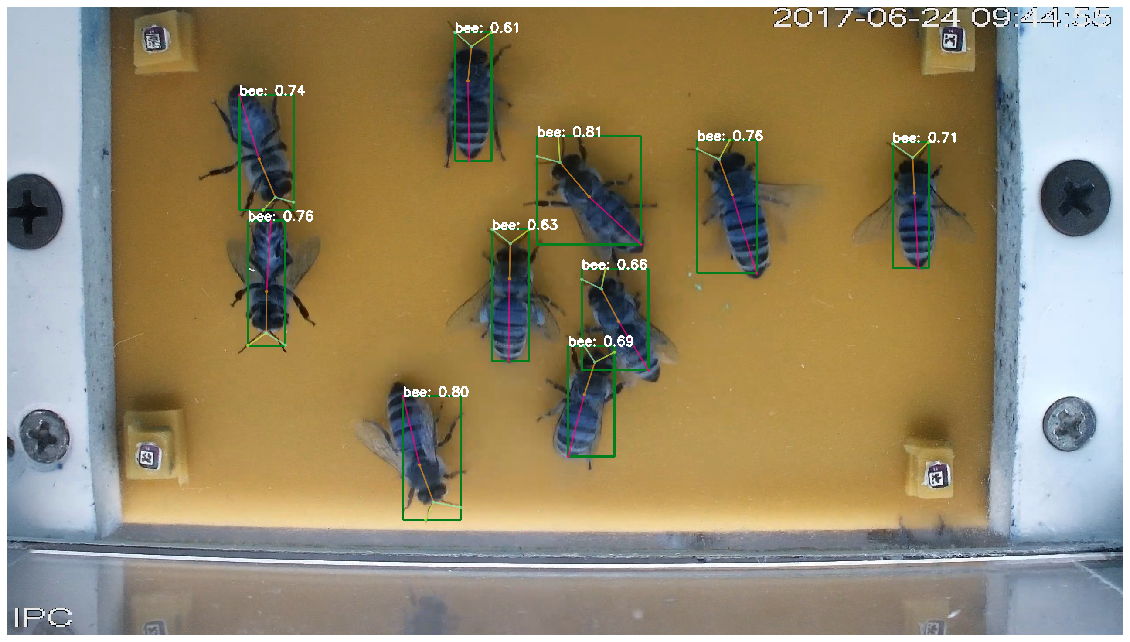

In [33]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "25"
its = range(1000,1501,1000)
its = range(500,3501,1000)

sts = ["standard_res1/3","standard_res_f5_test_.001_1/3","standard_res_f65_test_.0003_1/3"]
cs = ["beta_test/combined_res_f5_test_.001_beta1/2", "beta_test/combined_res_f65_test_.0003_beta1/2"]

loss = cs[1]
#its = [1500]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        imshow(predictions[:, :, [2, 1, 0]])
        plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']         
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                #print(p['id'])
                #bb = p["segmentation"]#p['bbox']
                bb = p['bbox']
                #bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_val = p["keypoints"]
                #print('kps val', kps_val)
                # comment for test and remove og
                #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps val", kps_pred)
                #print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print(diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    c_2_1.append(mse_test)
    print("mse yo", mse_test)


In [34]:
#print(s_1, len(s_1))
#print(s_2, len(s_2))
#print(s_3, len(s_3))
#452498234004, 9133.592689629197, 7965.038921178797, 7353.186608055335]
print(c_1_01,len(c_1_01))
print(c_2_01,len(c_2_01))

print(c_1_1,len(c_1_1))
print(c_2_1,len(c_2_1))

print(c_1_10,len(c_1_10))
print(c_2_10,len(c_2_10))

#s_1 = [88186.82241088747, 17781.53153187159, 11009.73844185224, 16453.053003257646, 11392.85310484681, 8881.294569746264]


[8629.956712723446, 7628.830853136663, 7795.114556678066, 7576.751472931871, 9328.647010185758] 5
[12150.95997184701, 12222.701188759263, 12857.375051830271, 12733.02563733375, 12373.101187628725] 5
[8468.039749002795, 10722.154769202047, 10025.89632871906, 10017.387008860162, 11501.747819214674] 5
[11174.784182303141, 12071.49577034067, 11706.26810947375, 11938.579277810566, 11639.17349468977] 5
[12050.372285828536, 9000.459795623136, 11175.084688550201, 12169.993414972518, 11400.111768410856] 5
[9094.324813485235, 11208.526793399687, 11763.43371888798, 11342.085888945694, 13010.65180068807] 5


In [ ]:
import numpy as np
bu = np.array([7200])
bu = (np.repeat(bu, 8, axis=0)).tolist()
print(bu)
td = np.array([6900])
td = np.repeat(td, 8, axis=0).tolist()
print(td)

In [ ]:
# make avgs
c5 = []
for s1,s2,s3 in zip(c_1_5,c_2_5,c_3_5):
    c5.append(((s1+s2+s3)/3))
print(c5,len(cp1))

In [ ]:
it7 = range(3000,10001,1000)
it3 = range(3000,10001,1000)
#it7=it5[2:]
it_c = range(3000,10001,500)
#it2 = range(8000,10001,500)
#it3 = range(9500,10001,500)
it2 = range(5500,10001,500)
it1 = range(7000,10001,500)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE: trained on rescaled")
colors = ['r','b','y','g']


plt.plot(it7, sa, '-o', c='orange', label="standard")

plt.plot(it3, c_1_01, '-o', c='blue', label="alpha =.0001")
plt.plot(it3, c_2_01, '-o', c='blue', label="alpha =.0001")
#plt.plot(it3, c_3_0001, '-o', c='blue', label="alpha =.0001")
#plt.plot(it3, c0001, '-o', c='blue', label="alpha =.0001")

#plt.plot(it3, c_1_001, '-o', c='#65BFE5', label="alpha =.001")
#plt.plot(it3, c_2_001, '-o', c='#65BFE5', label="alpha =.001")
#plt.plot(it3, c_3_001, '-o', c='#65BFE5', label="alpha =.001")
#plt.plot(it3, c001, '-o', c='#65BFE5', label="alpha =.001")

#plt.plot(it3, c_1_01, '-o', c='#4E869E', label="alpha =.01")
#plt.plot(it3, c_2_01, '-o', c='#4E869E', label="alpha =.01")
#plt.plot(it3, c_3_01, '-o', c='#4E869E', label="alpha =.01")
#plt.plot(it3, c01, '-o', c='#4E869E', label="alpha =.01")

#plt.plot(it3, c_1_p1, '-o', c='#6676D9', label="alpha =.1")
#plt.plot(it3, c_2_p1, '-o', c='#6676D9', label="alpha =.1")
#plt.plot(it3, c_3_p1, '-o', c='#6676D9', label="alpha =.1")
#plt.plot(it3, cp1, '-o', c='#6676D9', label="alpha =.1")

#plt.plot(it3, c_1_1, '-o', c='#54FEA1', label="alpha =1")
#plt.plot(it3, c_2_1, '-o', c='#54FEA1', label="alpha =1")
#plt.plot(it3, c_3_1, '-o', c='#54FEA1', label="alpha =1")
#plt.plot(it3, c1, '-o', c='#54FEA1', label="alpha =1")

#plt.plot(it3, c_1_5, '-o', c='#54E7FE', label="alpha =5")
#plt.plot(it3, c_2_5, '-o', c='#54E7FE', label="alpha =5")
#plt.plot(it3, c_3_5, '-o', c='#54E7FE', label="alpha =5")
#plt.plot(it3, c5, '-o', c='#54E7FE', label="alpha =5")


plt.plot(it7, bu,'-o', c='red', label="bottom up")
plt.plot(it7, td,'-o', c='green', label="top down")

    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap_un2" +'.png')
plt.show()

In [ ]:
it7 = range(2000,10001,500)
#it7=it5[2:]
it_c = range(3000,10001,500)
#it2 = range(8000,10001,500)
#it3 = range(9500,10001,500)
it2 = range(5500,10001,500)
it1 = range(7000,10001,500)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE: trained on rescaled")
colors = ['r','b','y','g']

plt.plot(it7, s_1[2:], '-o', c='orange', label="standard lr=.01,lr=.001,lr=.0003")
#plt.errorbar(it7, s_avg[5:], yerr=s_diff[5:], xerr=None, fmt='', ecolor='grey',c='grey',label="standard lr=.01,lr=.001,lr=.0003"
            #,elinewidth=None, capsize=16, capthick=3)
#plt.errorbar(it1, c_avg[1:], yerr=c_diff[1:], xerr=None, fmt='', ecolor='blue',c='blue',label="combined lr=.01,lr=.001,lr=.0003",capsize=16, capthick=3)
#plt.errorbar(it2, cu_avg, yerr=cu_diff, xerr=None, fmt='', ecolor='purple',c='purple',label="combined with unlabeled  lr=.01,lr=.001,lr=.0003",capsize=16, capthick=3)
plt.plot(it_c, c_1, '-o', c='blue', label="alpha=.001, combined lr=.01,lr=.001,lr=.0003")
plt.plot(it_c, com0001, '-o', c='#7276E8', label="alpha=.0001, combined lr=.01,lr=.001,lr=.0003")
plt.plot(it_c, comp00001, '-o', c='#33B0E3', label="alpha=.00001, combined lr=.01,lr=.001,lr=.0003")

plt.plot(it_c, comp1, '-o', c='#9DE2FF', label="alpha=.1, combined lr=.01,lr=.001,lr=.0003")


plt.plot(it2, cu_1, '-o', c='grey', label="combined unlabeled beta = 1, = lr=.01,lr=.001,lr=.0003")
plt.plot(it2, cu_2, '-o', c='pink', label="combined unlabeled beta = 10,lr=.01,lr=.001,lr=.0003")
plt.plot(it1, cu_1_001, '-o', c='brown', label="combined unlabeled beta = 1,.001,lr=.01,lr=.001,lr=.0003")
#plt.plot(it2, cu_avg, '-o', c='purple', label="combined with unlabeled  lr=.01,lr=.001,lr=.0003")


#plt.plot(it7, small_c,'-o', c='blue', label="combined")
plt.plot(it7, bu[0:17],'-o', c='red', label="bottom up")
plt.plot(it7, td[0:17],'-o', c='green', label="top down")
    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap_un2" +'.png')
plt.show()